# Analysis and Feature extraction

---

Once the data has been downloaded and preprocessed, the next step is to extract meaningful information from it. This phase is crucial in any remote sensing project, as it transforms raw pixel values into interpretable features for analysis or modeling.

This section introduces common techniques used to extract features from satellite imagery and geospatial data.

---

## Import

In [1]:
from osgeo import gdal,osr,gdalconst
gdal.UseExceptions()

import numpy as np
import matplotlib.pyplot as plt

---

## Display RGB

Before interpreation or analysis, we can display an RGB image to see what we have. For all example below, we use the file : *S2A_MSIL2A_20190305T222531_N0500_R029_T59GPM_20221119T040431*.SAFE found in copernicus. This file has been stack in tif.

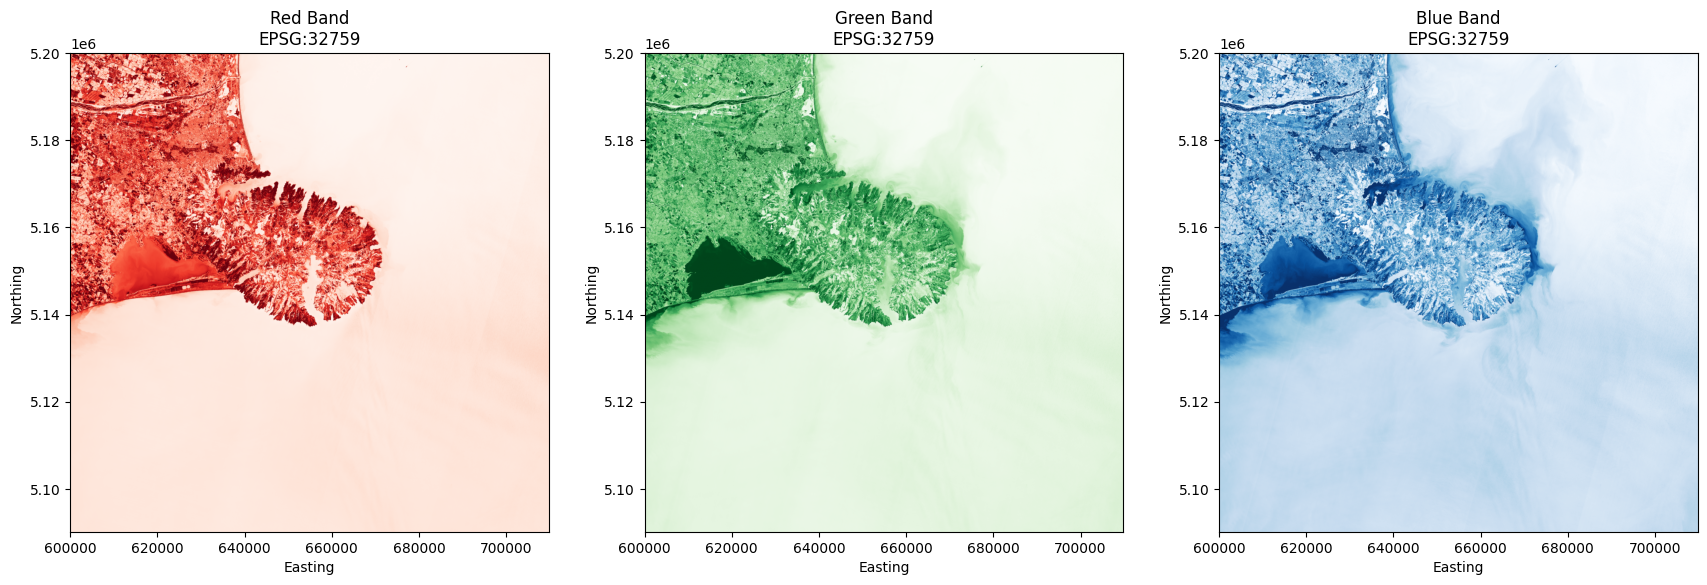

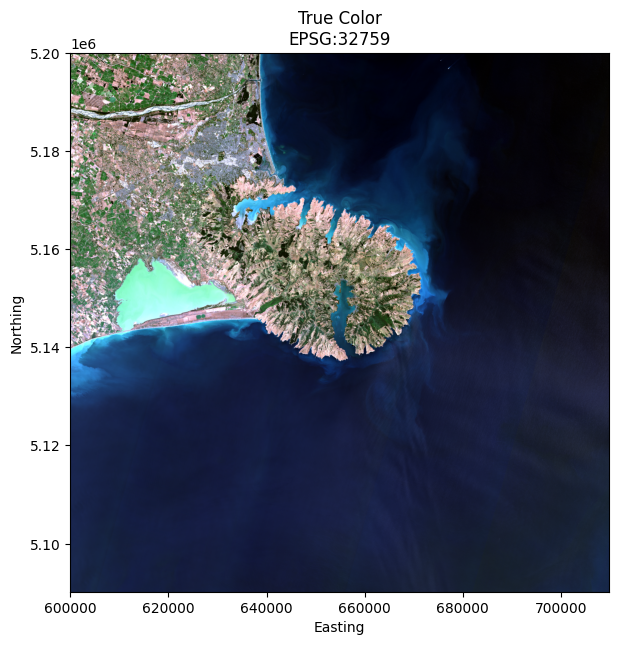

In [ ]:
def display_rgb(path, bands_rgb=(4, 3, 2), clipmin=2, clipmax=98):

    dataset = gdal.Open(path)
    # Projection
    gt = dataset.GetGeoTransform()
    proj = dataset.GetProjection()
    srs = osr.SpatialReference()
    srs.ImportFromWkt(proj)
    epsg = srs.GetAttrValue("AUTHORITY", 1)
    projection_str = f"EPSG:{epsg}" if epsg else "Unknow projection"

    # Spatial extent
    cols, rows = dataset.RasterXSize, dataset.RasterYSize
    xmin = gt[0]
    xmax = xmin + cols * gt[1]
    ymax = gt[3]
    ymin = ymax + rows * gt[5]
    extent = [xmin, xmax, ymin, ymax]

    def read_and_stretch(index):
        band = dataset.GetRasterBand(index).ReadAsArray().astype(np.float32)
        minval = np.percentile(band, clipmin)
        maxval = np.percentile(band, clipmax)
        stretched = np.clip((band - minval) / (maxval - minval) * 255, 0, 255).astype(np.uint8)
        return stretched

    r = read_and_stretch(bands_rgb[0])
    g = read_and_stretch(bands_rgb[1])
    b = read_and_stretch(bands_rgb[2])
    rgb = np.dstack((r, g, b))
    dataset=None
    
    # Band display
    fig, axs = plt.subplots(1, 3, figsize=(21, 7))
    for ax, band, title, cmap in zip(axs, [r, g, b], ["Red", "Green", "Blue"], ['Reds', 'Greens', 'Blues']):
        ax.imshow(band, cmap=cmap, extent=extent)
        ax.set_title(f"{title} Band\n{projection_str}")
        ax.set_xlabel("Easting")
        ax.set_ylabel("Northing")

    # RGB composite
    plt.figure(figsize=(7, 7))
    plt.imshow(rgb, extent=extent)
    plt.title(f"True Color\n{projection_str}")
    plt.xlabel("Easting")
    plt.ylabel("Northing")
    plt.show()

display_rgb("S2A_MSIL2A_20190305T222531_N0500_R029_T59GPM_20221119T040431.tif")


---

## Analysis

### A. Spectral Index

The first and most common analysis we can do is an utilisation of spectral index like NDVI (Normalized Difference Vegetation Index).
To calculate the NDVI, we just need to do :
    
    NDVI = (nir-red)/(nir+red)
nir : Infrared band, red : Red band

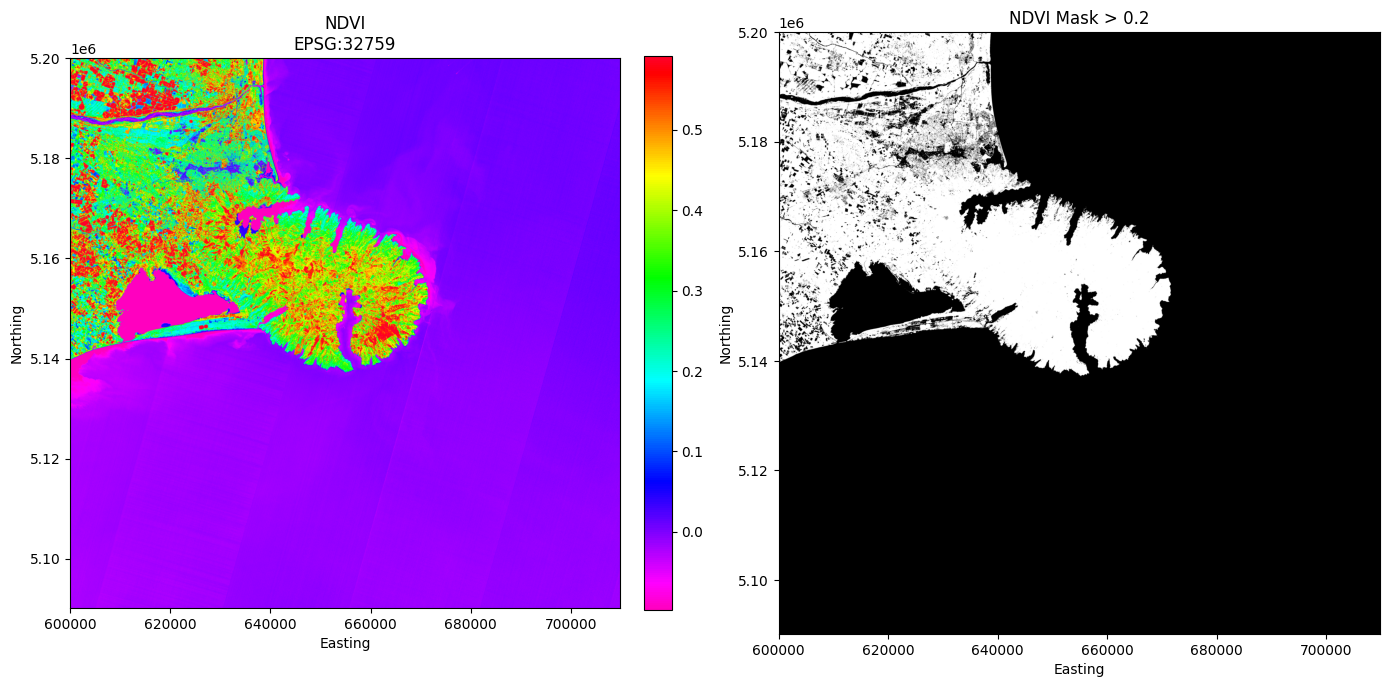

In [2]:
path = "S2A_MSIL2A_20190305T222531_N0500_R029_T59GPM_20221119T040431.tif"
scalefactor = 10000
#NDVI
dataset = gdal.Open(path)
r = dataset.GetRasterBand(4).ReadAsArray() / scalefactor
nir = dataset.GetRasterBand(8).ReadAsArray() / scalefactor
ndvi = (nir - r) / (nir + r)
veg_mask = ndvi > 0.2
# Spatial extent
gt = dataset.GetGeoTransform()
proj=dataset.GetProjection()
cols = dataset.RasterXSize
rows = dataset.RasterYSize
xmin = gt[0]
xmax = xmin + cols * gt[1]
ymax = gt[3]
ymin = ymax + rows * gt[5]
extent = [xmin, xmax, ymin, ymax]
dataset=None
# Projection
srs = osr.SpatialReference()
srs.ImportFromWkt(proj)
epsg = srs.GetAttrValue("AUTHORITY", 1)
projection_str = f"EPSG:{epsg}" if epsg else "Unknow Projection"
# Display
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
im1 = ax1.imshow(ndvi, cmap='gist_rainbow_r',vmin=np.percentile(ndvi, 2),vmax=np.percentile(ndvi, 98),extent=extent)
ax1.set_title(f"NDVI\n{projection_str}")
ax1.set_xlabel("Easting")
ax1.set_ylabel("Northing")
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
im2 = ax2.imshow(veg_mask, cmap='gray', extent=extent)
ax2.set_title("NDVI Mask > 0.2")
ax2.set_xlabel("Easting")
ax2.set_ylabel("Northing")
plt.tight_layout()
plt.show()
#If we want to save the NDVI
driver = gdal.GetDriverByName("GTiff")
out_ds = driver.Create("NDVI.tif", cols, rows, 1)
out_ds.SetGeoTransform(gt)
out_ds.SetProjection(proj)
out_ds.GetRasterBand(1).WriteArray(ndvi)
out_ds.FlushCache()
out_ds = None

### B. Filter

In remote sensing, filters are essential tools used to enhance, modify, or extract information from satellite or aerial imagery. These operations play a key role in both preprocessing and image analysis.

Filtering works by applying a kernel (a small matrix of weights) over each pixel of the image. The new value of a pixel is calculated based on its neighborhood and the kernel’s weights. This process allows various transformations depending on the filter type.

Below, we will apply a Sobel filter and Gaussian filter to our NDVI previously created. The sobel filter will bring out the edge effects between different NDVI values. While the Gaussian filter will smooth and reduce noise.

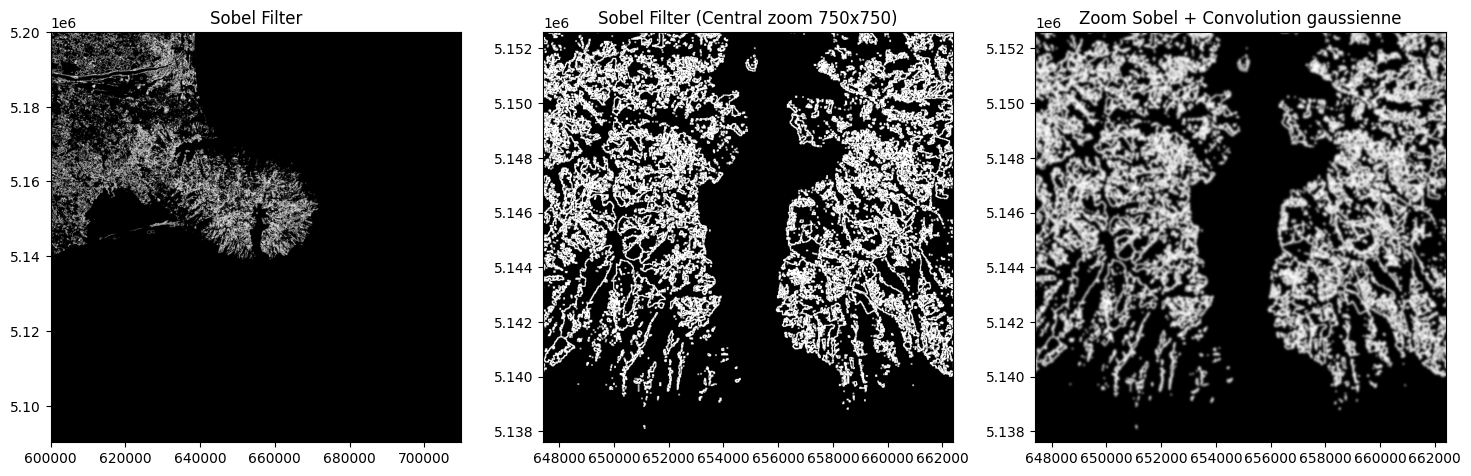

In [7]:
from scipy import ndimage

path = "NDVI.tif"
ds = gdal.Open(path)
ndvi = ds.GetRasterBand(1).ReadAsArray().astype(np.float32)
# ndvi = (ndvi - ndvi.min()) / (ndvi.max() - ndvi.min()) if we need a normalization
cols, rows = ds.RasterXSize, ds.RasterYSize
gt = ds.GetGeoTransform()
ds = None
#Sobel filter
sobel_h = ndimage.sobel(ndvi, 0) # horizontal gradient
sobel_v = ndimage.sobel(ndvi, 1) # vertical gradient
sobel_vh = np.clip(np.hypot(sobel_h, sobel_v), 0, 1)
#Spatial extent and zoom
extent = [gt[0], gt[0] + cols * gt[1], gt[3] + rows * gt[5], gt[3]]
c_r, c_c = rows // 2, cols // 2
z = 750 #zoom 
r0, r1 = max(c_r - z//2, 0), min(c_r + z//2, rows)
c0, c1 = max(c_c - z//2, 0), min(c_c + z//2, cols)
zoom_extent = [extent[0] + c0*gt[1], extent[0] + c1*gt[1], extent[3] + r1*gt[5], extent[3] + r0*gt[5]]
# Gaussian filter
gaussian = ndimage.gaussian_filter(sobel_vh, sigma=2, mode='reflect')
#Display
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
vmin,vmax=np.percentile(sobel_vh,2),np.percentile(sobel_vh,98)
ax1.imshow(sobel_vh, cmap='gray', vmin=vmin, vmax=vmax, extent=extent)
ax1.set_title('Sobel Filter')
ax2.imshow(sobel_vh[r0:r1, c0:c1], cmap='gray', vmin=vmin, vmax=vmax,extent=zoom_extent)
ax2.set_title(f'Sobel Filter (Central zoom {z}x{z})')
ax3.imshow(gaussian[r0:r1, c0:c1], cmap='gray', vmin=vmin, vmax=vmax,extent=zoom_extent)
ax3.set_title('Zoom Sobel + Convolution gaussienne')
plt.show()

### C. Image reduction (PCA)

Principal Component Analysis (PCA) is a widely used technique in remote sensing to reduce the dimensionality of multispectral or hyperspectral image data. Sentinel-2 images typically contain 10 or more spectral bands, many of which are highly correlated. PCA transforms these bands into a smaller set of uncorrelated components (called principal components) that capture the most significant variance in the data.


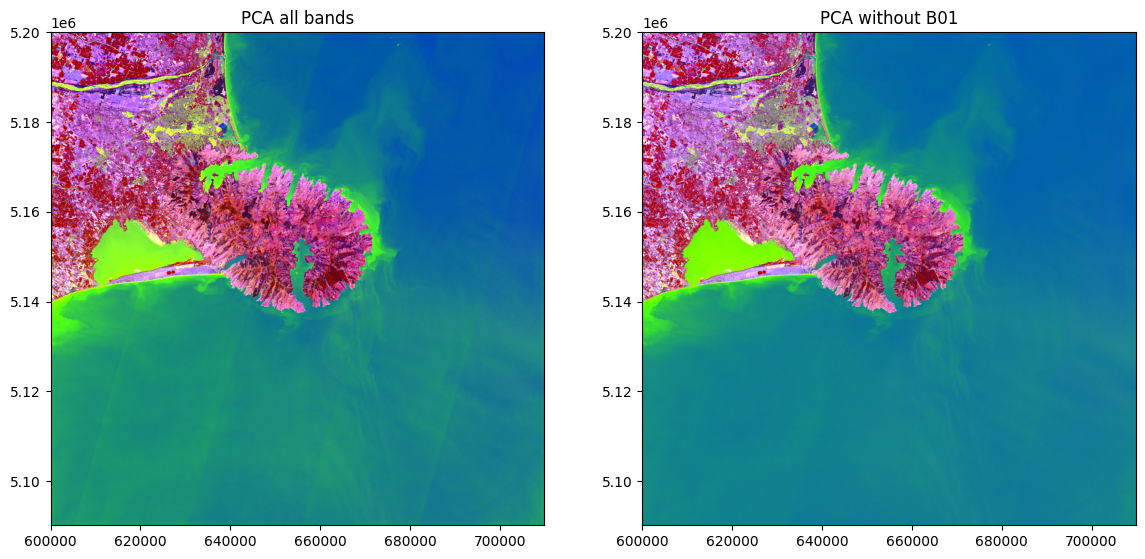

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

stack_path = "S2A_MSIL2A_20190305T222531_N0500_R029_T59GPM_20221119T040431.tif"
dataset = gdal.Open(stack_path)
gt = dataset.GetGeoTransform()
proj=dataset.GetProjection()
rows = dataset.RasterYSize
cols = dataset.RasterXSize
bands = dataset.RasterCount
extent = [gt[0], gt[0] + cols * gt[1], gt[3] + rows * gt[5], gt[3]]
# Shape (rows, cols, bands)
stack = np.zeros((rows, cols, bands))
for i in range(bands):
    band = dataset.GetRasterBand(i + 1)
    stack[:, :, i] = band.ReadAsArray()
dataset = None
# PCA with all bands
stack_2D_all = stack.reshape((-1, bands)) 
scaler_all = StandardScaler()
stack_scaled_all = scaler_all.fit_transform(stack_2D_all) # shape = (rows*cols, bands)
pca_all = PCA(n_components=3)
reduced_all = pca_all.fit_transform(stack_scaled_all)
reduced_img_all = reduced_all.reshape((rows, cols, 3))
# PCA without band 1
stack_2D_noB1 = stack_2D_all[:, 1:]  # Delete first col = B01
scaler_noB1 = StandardScaler()
stack_scaled_noB1 = scaler_noB1.fit_transform(stack_2D_noB1)
pca_noB1 = PCA(n_components=3)
reduced_noB1 = pca_noB1.fit_transform(stack_scaled_noB1)
reduced_img_noB1 = reduced_noB1.reshape((rows, cols, 3))
# Normalization and Stretching
def stretch_percentile(image, lower=2, upper=98):
    p_low = np.percentile(image, lower, axis=(0, 1))
    p_high = np.percentile(image, upper, axis=(0, 1))
    stretched = (image - p_low) / (p_high - p_low)
    return np.clip(stretched, 0, 1)
def minmax_normalize(image):
    min_ = image.min(axis=(0, 1), keepdims=True)
    max_ = image.max(axis=(0, 1), keepdims=True)
    return (image - min_) / (max_ - min_)
normalized_all = minmax_normalize(reduced_img_all)
normalized_noB1 = minmax_normalize(reduced_img_noB1)
stretched_all = stretch_percentile(normalized_all)
stretched_noB1 = stretch_percentile(normalized_noB1)
# Display
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(stretched_all, extent=extent)
axes[0].set_title("PCA all bands")
axes[1].imshow(stretched_noB1, extent=extent)
axes[1].set_title("PCA without B01")
plt.show()
# Save
def save_tif(output_path, array, geotransform, projection, dtype=gdal.GDT_Float32):
    rows, cols, bands = array.shape
    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(output_path, cols, rows, bands, dtype)
    out_ds.SetGeoTransform(geotransform)
    out_ds.SetProjection(projection)
    for i in range(bands):
        out_ds.GetRasterBand(i + 1).WriteArray(array[:, :, i])
    out_ds.FlushCache()
    out_ds = None
save_tif("PCA_allbands.tif", normalized_all, gt, proj)
save_tif("PCA_noB1.tif", normalized_noB1, gt, proj)